# Creating an Open Data Cube from STAC records

This notebook takes you through my thinking and testing so far in trying to generate an open data cube using the CEDA Sentinel 2 ARD STAC catalogue.
The main sticking point is the fact that the band information is described under eo:bands. 

I imagine that it must be possible to create an open data cube using, for example, all the red bands referenced under eo:bands, although many public datasets seem to have the individual spectral bands split out as individual assets.

Requirements (can be installed using `pip` on the EODh AppHub or through your environment manager):

* dask
* folium
* geopandas
* shapely
* pyproj
* Ipython
* pystac_client
* stackstac
* odc-stac
* rioxarray

In [1]:
# Imports
import dask.distributed
import dask.diagnostics

import folium
import geopandas as gpd

import shapely.geometry
import pyproj

from IPython.display import display
from pystac_client import Client

# the data cube bit
from odc.stac import configure_rio, stac_load 
import stackstac

In [2]:
#common variables
lon, lat = -1.3144, 51.5755 # Atlas building at RAL

EURL = "https://earth-search.aws.element84.com/v1"
CURL = "https://api.stac.ceda.ac.uk/"

# STACKSTAC and Element-84 STAC 
The first thing I wanted to do was prove that it is possible to create an ODC from a STAC catalogue. To do this I followed the `stackstac` example using Element-84s STAC dataset:   

See - https://stackstac.readthedocs.io/en/latest/basic.html 

In [4]:
# Connect and search STAC catalogue
catalog = Client.open(EURL)

items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-2-l2a"],
    datetime="2023-05-01/2023-11-30"
).item_collection()
len(items)

76

In [5]:
# Use stackstac to turn STAC items into a lazy xarray. 
# Using all the defaults, our data will be in its native coordinate reference system, at the finest resolution of all the assets.

stack = stackstac.stack(items)

/home/al/miniforge3/envs/eodh/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [6]:
# Filter out scenes with >15% cloud coverage (according to the eo:cloud_cover field). 
# Then, pick the bands corresponding to red, green, and blue, and use xarray’s resample to create 1-month median composites.

lowcloud = stack[stack["eo:cloud_cover"] < 15]
rgb = lowcloud.sel(band=["red", "green", "blue"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

/home/al/miniforge3/envs/eodh/lib/python3.12/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/home/al/miniforge3/envs/eodh/lib/python3.12/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


In [7]:
# we don't want all the data so we slice out a little region around our area of interest.
# Convert our lat-lon point to the data’s coordinate reference system, then use that to slice the x and y dimensions.

x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 500  # meters
aoi = monthly.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-1b700e7881038b247c2b451c3e1547c4' (time: 7,
                                                                band: 3,
                                                                y: 100, x: 100)> Size: 2MB
dask.array<getitem, shape=(7, 3, 100, 100), dtype=float64, chunksize=(3, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/23)
  * band                                     (band) <U12 144B 'red' ... 'blue'
  * x                                        (x) float64 800B 6.163e+05 ... 6...
  * y                                        (y) float64 800B 5.716e+06 ... 5...
  * time                                     (time) datetime64[ns] 56B 2023-0...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    mgrs:latitude_band                       <U1 4B 'U'
    ...                                       ...
    raster:bands                             (band) object 24B [{'nodata': 0,...
    gsd                                      (band) object 24B 10 10 10
    common_name                              (band) object 24B 'red' ... 'blue'
    center_wavelength                        (band) object 24B 0.665 0.56 0.49
    full_width_half_max                      (band) object 24B 0.038 0.045 0.098
    epsg                                     int64 8B 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(600000.0, 5690220.0, 709800.0...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5800020.00|\n| 0.0...
    resolution:  10.0

[########################################] | 100% Completed | 43.78 s


/home/al/miniforge3/envs/eodh/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


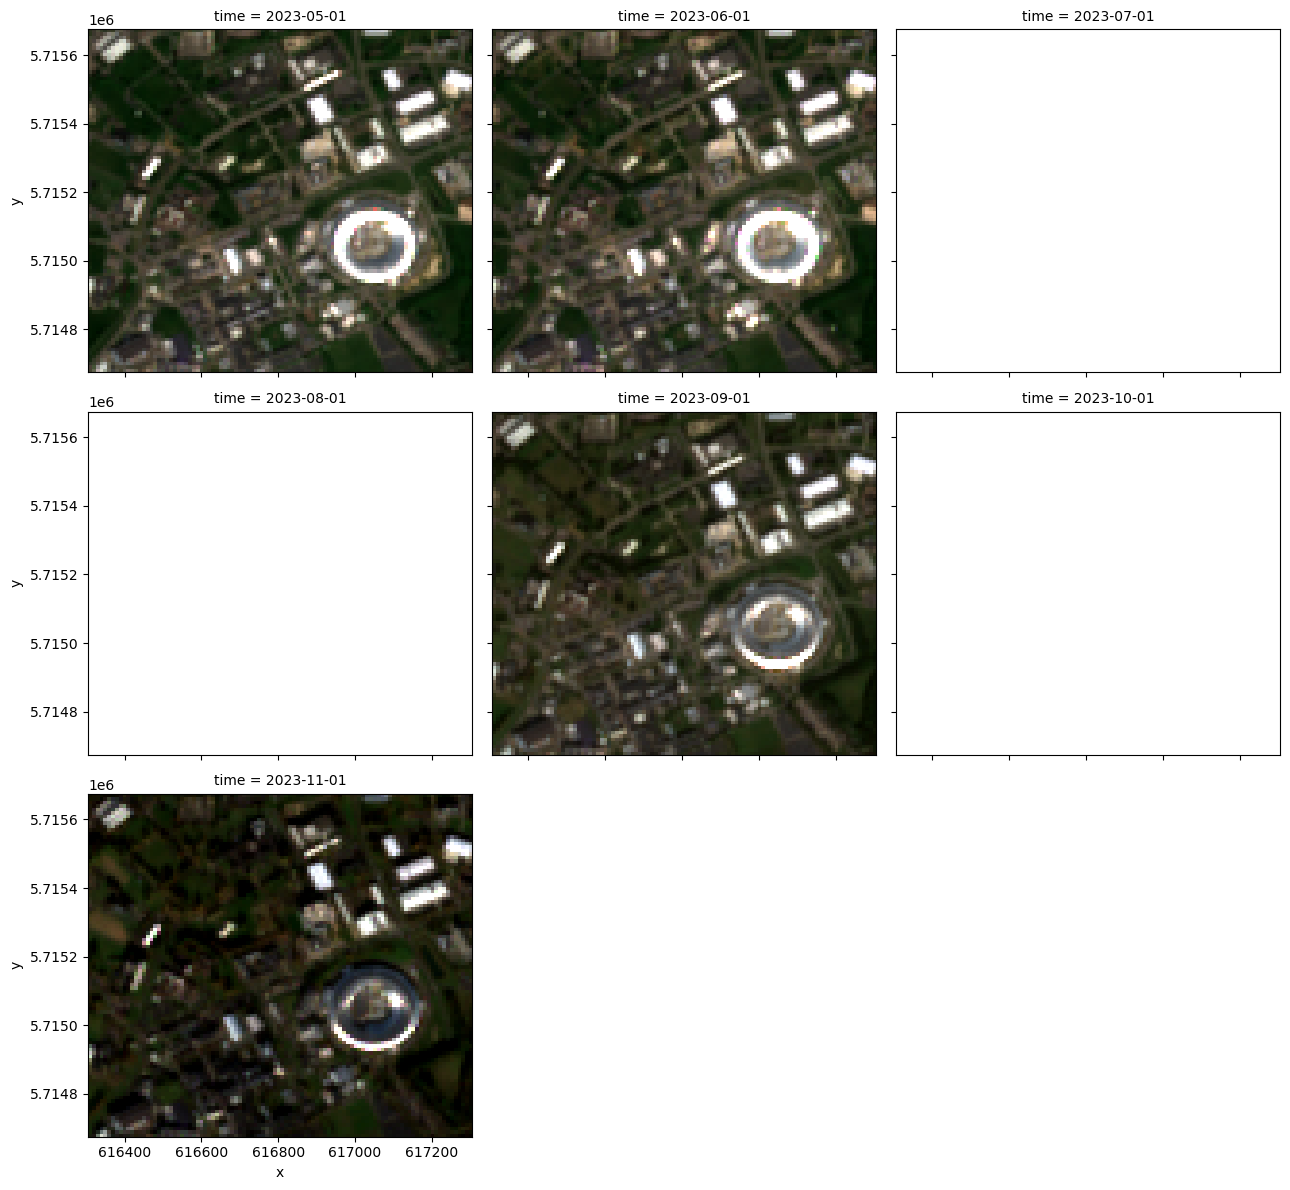

In [8]:
with dask.diagnostics.ProgressBar():
    data = aoi.compute()

# show the monthly composites where they exist
data.plot.imshow(row="time", rgb="band", robust=True, size=4, col_wrap=3);

This means we can be confident that this works for the Element 84 Sentinel data - blank plots are where there are not enough cloud free images in a month to create the composites.
 

# STACKSTAC and CEDA STAC
This next series of cells tries to replicate the processing process above (i.e. using stackstac) but with the CEDA S2 ARD catalogue  

In [10]:
# Connect and search STAC catalogue
ccatalog = Client.open(CURL)

citems = ccatalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel2_ard"],
    datetime="2023-05-01/2023-11-30"
).item_collection()
len(citems)

40

In [11]:
mystack = stackstac.stack(citems)

/home/al/miniforge3/envs/eodh/lib/python3.12/site-packages/stackstac/prepare.py:103: UserWarning: You're filtering for assets that match the mimetype(s) frozenset({'image/jp2', 'image/tiff', 'image/vnd.stac.geotiff', 'image/x.geotiff'}), but since 8 (out of 8) asset(s) have no `type` specified on any item, those will be dropped. Consider passing a list of asset IDs instead to the `assets=` parameter.
Assets with no type: ['cloud', 'cloud_probability', 'metadata', 'thumbnail', 'topographic_shadow', 'cog', 'valid_pixels', 'saturated_pixels']
  warnings.warn(


ValueError: Zero asset IDs requested

This doesn't work out of the box. There are a number of arguements that we can look at: https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html

In [12]:
mystack = stackstac.stack(citems, assets=citems.extra_fields['eo.bands'], epsg=27700)


KeyError: 'eo.bands'

Somewhere my referencing isn't correct. So we should have a look at where the various information resides. My understanding is that we would need to reference the `cog.href` and then the bands from there

In [13]:
# Make sure we know that the bands are discoverable

# Pick the first item to inspect the assets
item = citems[0]

# Inspect assets in the item
for asset_key, asset in item.assets.items():
    print(f"Asset: {asset_key}")
    
    # Check if the asset has eo:bands metadata
    if 'eo:bands' in asset.extra_fields:
        bands = asset.extra_fields['eo:bands']
        for band in bands:
            print(f"Band: {band['name']} - {band['description']} - {band['common_name']} ")

Asset: cloud
Asset: cloud_probability
Asset: metadata
Asset: thumbnail
Asset: topographic_shadow
Asset: cog
Band: B02 - Blue - blue 
Band: B03 - Green - green 
Band: B04 - Red - red 
Band: B05 - Visible and Near Infrared - rededge 
Band: B06 - Visible and Near Infrared - rededge 
Band: B07 - Visible and Near Infrared - rededge 
Band: B08 - Visible and Near Infrared - nir 
Band: B08a - Visible and Near Infrared - nir08 
Band: B11 - Short Wave Infrared - swir16 
Band: B12 - Short Wave Infrared - swir22 
Asset: valid_pixels
Asset: saturated_pixels


So we know that we can see the band information held in `eo:bands`, and that the asset is `cog` which has an associated url to the tif. 

Let's compare items with citems and see how the structure differs

In [ ]:
items[0]

In [ ]:
citems[0]

In [16]:
# Sense check that I can see the information I need to 
stac_item = citems[1]
print(stac_item.assets['cog'].href)
stac_item.assets['cog'].extra_fields['eo:bands'][1]['name']


https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/11/17/S2A_20231117_latn518lonw0008_T30UXC_ORB137_20231117131218_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif


'B03'

There is some interesting information here: https://github.com/stac-extensions/eo?tab=readme-ov-file#spectral-bands


# Workaround?
Basically we just want to be able to create an xarray object from the individual bands held in the CEDA STAC catalogue.

In [17]:
import rioxarray

# Access the URL for an individual CEDA STAC asset to test opening it using rioxarray
datafile = stac_item.assets['cog'].href

rds = rioxarray.open_rasterio(datafile, overview_level=3)
rds

<xarray.DataArray (band: 10, y: 695, x: 695)> Size: 10MB
[4830250 values with dtype=uint16]
Coordinates:
  * band         (band) int64 80B 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 6kB 4.305e+05 4.307e+05 ... 5.415e+05 5.417e+05
  * y            (y) float64 6kB 2.715e+05 2.713e+05 ... 1.605e+05 1.604e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

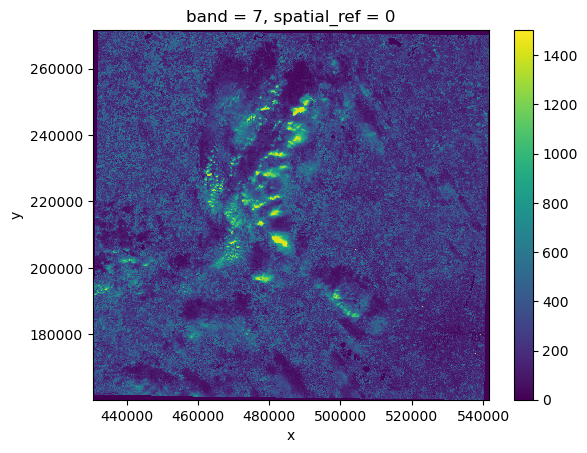

In [18]:
# Band=7 in this corresponds to the nir band
rds.sel(band=7).plot()

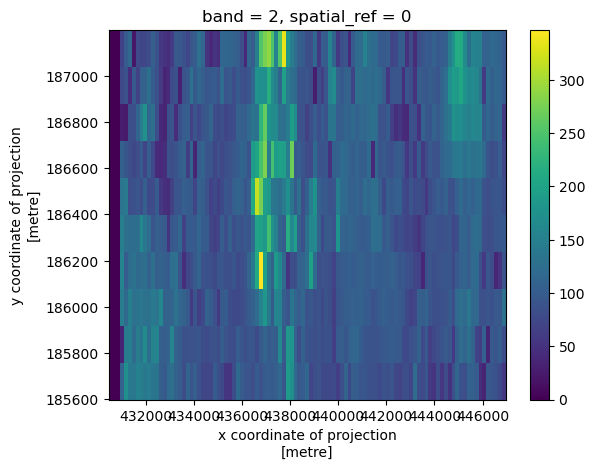

In [19]:
# Clip an area around the Harwell campus and show red band  
aoi_geom = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [446924.3516, 187299.2148],
            [448642.7644, 187286.4543],
            [48591.7224, 185606.3229],
            [446886.0701, 185602.0694],
            [446924.3516, 187299.2148],
        ]]
    }
]

clipped = rds.rio.clip(aoi_geom)
clipped.sel(band=2).plot()

This shows we can access the CEDA data as an xarray but it doesn't help us create a data cube as my understanding is that all COG layers need to be loaded before the filtering can be done.

Is this correct? Is there a way to just dump all the COG assests into xarray and then filter after that to tidy it up?

---

# ODC-STAC and Element-84

I thought that it would be useful to try another tool (odc-stac) to see if this was more useful. I followed the online tutorial.

See: https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html


In [20]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [21]:
# SET UP DASK CLIENT

client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client) # sets up gdal for cloud use

In [22]:
# FIND STAC ITEMS

# Set up a bounding box to limit te search
km2deg = 1.0 / 111
x, y = (lon, lat)  # Center point of a query
r = 25 * km2deg
bbox = (x - r, y - r, x + r, y + r)

catalog = Client.open(EURL)

query = catalog.search(
    collections=["sentinel-2-l2a"], datetime="2023-06-15", limit=100, bbox=bbox
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.item_collection_as_dict()

Found: 4 datasets


In [24]:
# REVIEW SEARCH RESULTS

gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id from components
gdf["granule"] = (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf["mgrs:grid_square"]
)

# https://github.com/python-visualization/folium/issues/1501
from branca.element import Figure

fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

/tmp/ipykernel_54469/1895939222.py:39: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))


In [25]:
items

[<Item id=S2B_30UWB_20230615_0_L2A>,
 <Item id=S2B_30UXB_20230615_0_L2A>,
 <Item id=S2B_30UWC_20230615_0_L2A>,
 <Item id=S2B_30UXC_20230615_0_L2A>]

In [26]:
# CONSTRUCT DASK DATASET

# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"
zoom = 2**5  # overview level 5

xx = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
)
display(xx)

<xarray.Dataset> Size: 28MB
Dimensions:      (y: 1074, x: 1072, time: 4)
Coordinates:
  * y            (y) float64 9kB 6.864e+06 6.864e+06 ... 6.521e+06 6.52e+06
  * x            (x) float64 9kB -3.339e+05 -3.336e+05 ... 8.48e+03 8.8e+03
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 32B 2023-06-15T11:16:53.575000 ... 202...
Data variables:
    red          (time, y, x) uint16 9MB dask.array<chunksize=(1, 1074, 1072), meta=np.ndarray>
    green        (time, y, x) uint16 9MB dask.array<chunksize=(1, 1074, 1072), meta=np.ndarray>
    blue         (time, y, x) uint16 9MB dask.array<chunksize=(1, 1074, 1072), meta=np.ndarray>

In [27]:
%%time
xx = xx.compute() # LOAD INTO LOCAL MEMORY

CPU times: user 623 ms, sys: 126 ms, total: 749 ms
Wall time: 10.3 s


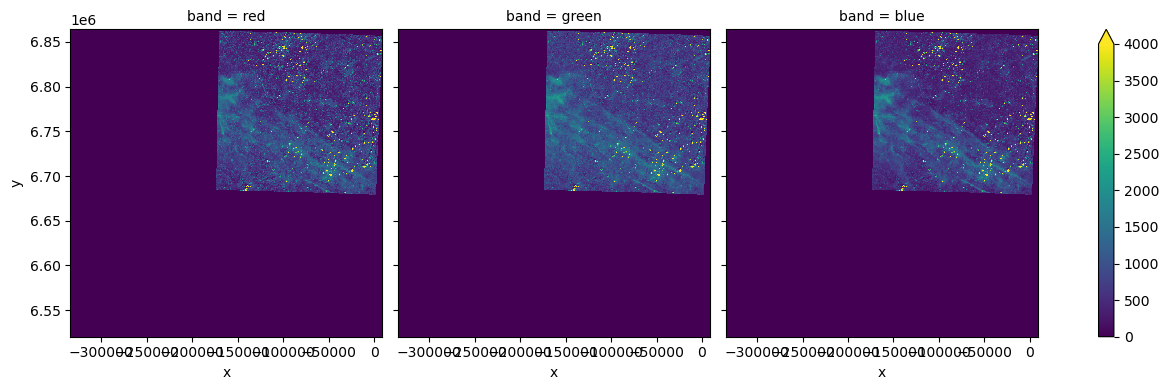

In [28]:
_ = (
    xx.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)

In [29]:
# rework to show the area around Harwell campus

r = 6.5 * km2deg
small_bbox = (x - r, y - r, x + r, y + r)

yy = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10,
    chunks={},  # <-- use Dask
    bbox=small_bbox,
)

yy = yy.compute()

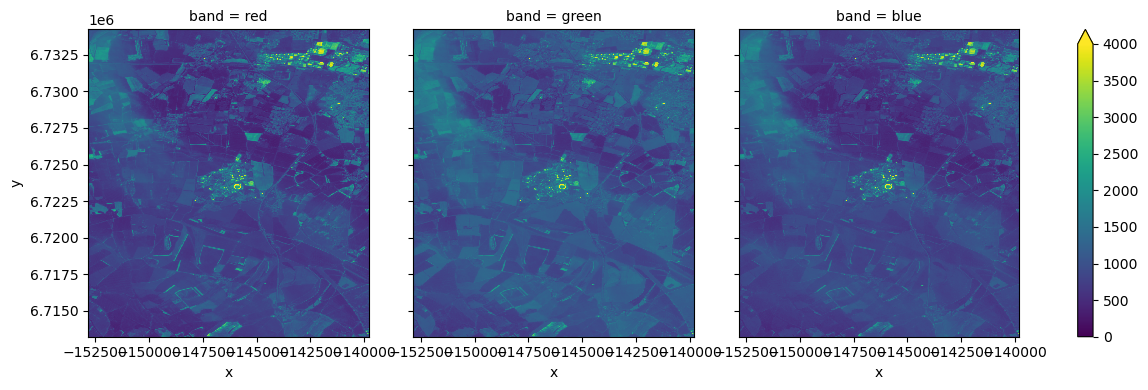

In [30]:
_ = (
    yy.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)

# ODC-STAC and CEDA ARD

Once again we have a look at using the CEDA STAC.

In [31]:
# SEARCH
catalog = Client.open(CURL)

query = catalog.search(
    collections=["sentinel2_ard"], datetime="2023-06-15", limit=100, bbox=bbox
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.item_collection_as_dict()

Found: 4 datasets


In [32]:
for key, value in items[1].assets.items():
    print(key, value.href)

cloud https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/15/S2B_20230615_latn518lonw0008_T30UXC_ORB137_20230615131239_utm30n_osgb_clouds.tif
cloud_probability https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/15/S2B_20230615_latn518lonw0008_T30UXC_ORB137_20230615131239_utm30n_osgb_clouds_prob.tif
metadata https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/15/S2B_20230615_latn518lonw0008_T30UXC_ORB137_20230615131239_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_meta.xml
thumbnail https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/15/S2B_20230615_latn518lonw0008_T30UXC_ORB137_20230615131239_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg
topographic_shadow https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/15/S2B_20230615_latn518lonw0008_T30UXC_ORB137_20230615131239_utm30n_osgb_toposhad.tif
cog https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/15/S2B_20230615_latn518lonw0008_T30UXC_ORB137_20

In [33]:
# REVIEW SEARCH RESULTS

gdf2 = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

f = folium.Figure(width=600, height=400)
m = folium.Map(location=[52, 2], zoom_start=5).add_to(f)

gdf2.explore(
    "esa_file_name",
    categorical=True,
    tooltip=[
        "esa_file_name",
    ],
    popup=False,
    name="STAC",
    m=m,
)


In [34]:
# CONSTRUCT DASK DATASET

# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"
zoom = 2**5  # overview level 5

cx = stac_load(
    items,
    crs=crs,
    resolution=10 * zoom,
    chunks={"x": 2048, "y": 2048},  # <-- use Dask
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(cx)

Bands: red,green,blue


<xarray.Dataset> Size: 32MB
Dimensions:             (y: 1073, x: 1072, time: 1)
Coordinates:
  * y                   (y) float64 9kB 6.864e+06 6.863e+06 ... 6.52e+06
  * x                   (x) float64 9kB -3.339e+05 -3.336e+05 ... 8.8e+03
    spatial_ref         int32 4B 3857
  * time                (time) datetime64[ns] 8B 2023-06-15T11:06:29
Data variables:
    cloud               (time, y, x) float32 5MB dask.array<chunksize=(1, 1073, 1072), meta=np.ndarray>
    cloud_probability   (time, y, x) float32 5MB dask.array<chunksize=(1, 1073, 1072), meta=np.ndarray>
    thumbnail           (time, y, x) float32 5MB dask.array<chunksize=(1, 1073, 1072), meta=np.ndarray>
    topographic_shadow  (time, y, x) float32 5MB dask.array<chunksize=(1, 1073, 1072), meta=np.ndarray>
    cog                 (time, y, x) float32 5MB dask.array<chunksize=(1, 1073, 1072), meta=np.ndarray>
    valid_pixels        (time, y, x) float32 5MB dask.array<chunksize=(1, 1073, 1072), meta=np.ndarray>
    saturated_pixels    (time, y, x) float32 5MB dask.array<chunksize=(1, 1073, 1072), meta=np.ndarray>

As you can see, the assets are the high level keys again. we want to be able to get a list of `cog.href` and the associated `eo:bands` information that goes with them. When compute is run, the following errors are returned.


In [35]:
cx = cx.compute()


/home/al/miniforge3/envs/eodh/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
2024-10-07 16:10:31,545 - distributed.worker - WARNING - Compute Failed
Key:       ('thumbnail-f42188f69d7a89dba4e2305f6a750c13', 0, 0, 0)
Function:  _dask_loader_tyx
args:      ([[RasterSource(uri='https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/15/S2B_20230615_latn509lonw0008_T30UXB_ORB137_20230615131239_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg', band=1, subdataset=None, geobox=None, meta=None), RasterSource(uri='https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2023/06/15/S2B_20230615_latn510lonw0022_T30UWB_ORB137_20230615131239_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref_thumbnail.jpg', band=1, subdataset=None, geobox=None, meta=None), RasterSource(uri='https://dap.ceda.ac.uk/neod

AssertionError: 